## Introduction

This notebook is part of an ongoing project to develop eMBLEM, a new method for measuring [relevant metric]. In this analysis, we compare eMBLEM against AH, which is considered the ground truth standard. The purpose of this notebook is to assess how well eMBLEM agrees with AH through various statistical analyses and visualizations.


## 1. Initial Setup and Data Loading

In this section, we import the necessary libraries, load the dataset, and define key variables that will be used throughout the analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, probplot
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import os
from PIL import Image
import ipywidgets as widgets
from matplotlib.colors import Normalize


# Load the dataset
file_path = 'data/sample_dataset.xlsx'
df = pd.read_excel(file_path)

# Define key variables
mean_emblem_AH = 'emblem_and_AH_MEAN'
difference_emblem_AH = 'emblem_error'
AH = df['ah_metric']
eMBLEM = df['emblem_metric']  
journal_id_column = 'journal_id'
type_column = 'type'  


FileNotFoundError: [Errno 2] No such file or directory: 'data/sample_dataset.xlsx'

## 2. Exploratory Data Analysis (EDA)

In this section, we explore the key metrics of AH and eMBLEM, focusing on the difference between them (`difference_emblem_AH`). Since AH is the ground truth, our goal is to understand how closely eMBLEM matches these established measurements.

count    683.000000
mean      -0.007789
std        2.629577
min      -13.297960
25%       -0.828498
50%        0.021565
75%        1.014599
max       14.936498
Name: emblem_error, dtype: float64


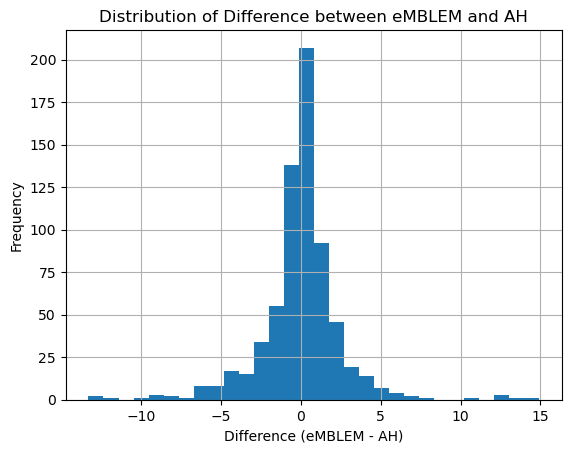

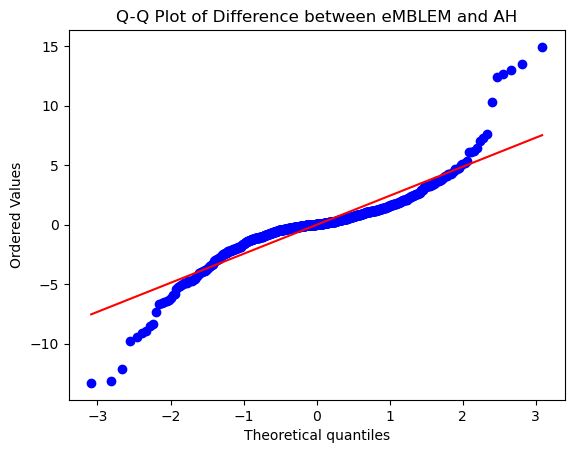

Statistic: 0.8593204003262003, p-value: 3.1506033849936916e-24
Data is not normally distributed.


In [2]:
# Descriptive statistics and histogram
print(df[difference_emblem_AH].describe())
df[difference_emblem_AH].hist(bins=30)
plt.title('Distribution of Difference between eMBLEM and AH')
plt.xlabel('Difference (eMBLEM - AH)')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot for normality check
probplot(df[difference_emblem_AH], dist="norm", plot=plt)
plt.title('Q-Q Plot of Difference between eMBLEM and AH')
plt.show()

# Shapiro-Wilk test for normality
stat, p_value = shapiro(df[difference_emblem_AH])
print(f'Statistic: {stat}, p-value: {p_value}')
if p_value > 0.05:
    print("Data is likely normally distributed.")
else:
    print("Data is not normally distributed.")


## 3. Interactive Bland-Altman Plot

In this section, we create an interactive Bland-Altman plot to visually assess the agreement between AH Volume and eMBLEM Volume. The plot allows you to dynamically filter data points based on overlap percentage, helping to identify patterns and outliers.

In [3]:

# Define normalization for the color scale
color_column = 'Overlapped Area Percentage BACK'
min_value = df[color_column].min()
max_value = df[color_column].max()
norm = Normalize(vmin=min_value, vmax=max_value)

# Store the full range of the x and y axis
x_min, x_max = df[mean_emblem_AH].min(), df[mean_emblem_AH].max()
y_min, y_max = df[difference_emblem_AH].min(), df[difference_emblem_AH].max()

# Calculate the mean bias and limits of agreement (LoA)
bias = df[difference_emblem_AH].mean()
loa_upper = bias + 1.96 * df[difference_emblem_AH].std()
loa_lower = bias - 1.96 * df[difference_emblem_AH].std()

# Function to update the plot based on the selected threshold
def update_plot(threshold):
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Filter the data based on the threshold
    filtered_df = df[df[color_column] >= threshold]
    
    # Scatter plot using the filtered data
    scatter = ax.scatter(
        filtered_df[mean_emblem_AH],
        filtered_df[difference_emblem_AH],
        c=filtered_df[color_column],
        cmap='RdYlGn_r',
        s=100,
        norm=norm
    )
    
    # Set the axis limits based on the full dataset
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Plot bias and limits of agreement
    ax.axhline(y=bias, color='blue', linestyle='--', label=f'Bias (Mean): {bias:.2f}')
    ax.axhline(y=loa_upper, color='red', linestyle='--', label=f'Upper LoA: {loa_upper:.2f}')
    ax.axhline(y=loa_lower, color='red', linestyle='--', label=f'Lower LoA: {loa_lower:.2f}')
    
    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=norm)
    sm.set_array(filtered_df[color_column])
    fig.colorbar(sm, ax=ax, label='Overlap Percentage')
    
    ax.set_xlabel(mean_emblem_AH)
    ax.set_ylabel(difference_emblem_AH)
    ax.set_title('Interactive Bland-Altman Plot with Overlap Percentage')
    ax.legend(loc='upper right')
    plt.show()

# Interactive slider to adjust the threshold
threshold_slider = widgets.FloatSlider(
    value=df[color_column].min(),
    min=df[color_column].min(),
    max=df[color_column].max(),
    step=0.1,
    description='Threshold:',
    continuous_update=False
)

# Link the slider to the update_plot function
interactive_plot = widgets.interactive(update_plot, threshold=threshold_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=0.16596441208944998, continuous_update=False, description='Threshold:'…

## 4. Linear Regression Analysis

Here, we perform a linear regression analysis to explore the relationship between AH [relevant metric] and eMBLEM [relevant metric]. We calculate the R² value to assess the fit of the model and visualize the regression line.

The R^2 value for AH vs eMBLEM is: 0.8516


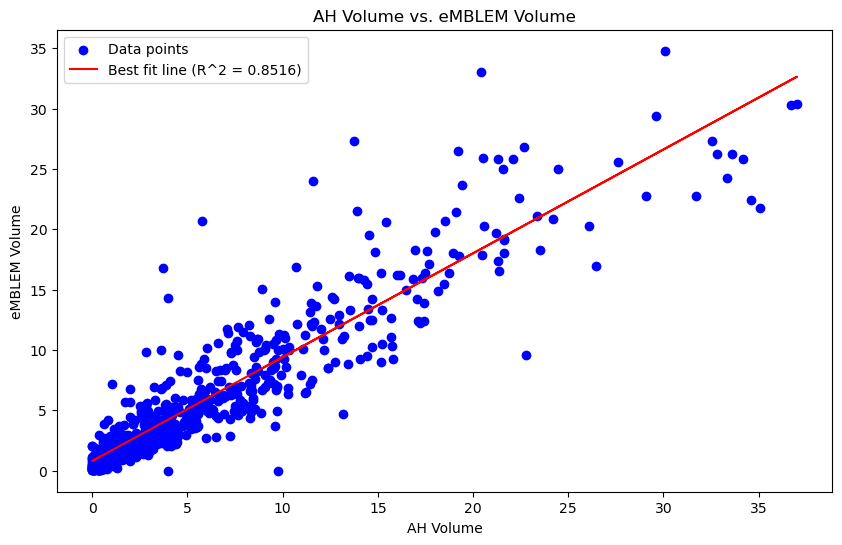

In [4]:
# Reshape the data for sklearn (necessary for the LinearRegression model)
AH_reshaped = AH.values.reshape(-1, 1)
eMBLEM_reshaped = eMBLEM.values.reshape(-1, 1)

# Fit a linear regression model
model = LinearRegression()
model.fit(AH_reshaped, eMBLEM_reshaped)

# Predict eMBLEM values based on the model
eMBLEM_pred = model.predict(AH_reshaped)

# Calculate the R^2 value
r2 = r2_score(eMBLEM_reshaped, eMBLEM_pred)
print(f"The R^2 value for AH vs eMBLEM is: {r2:.4f}")

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(AH, eMBLEM, color='blue', label='Data points')
plt.plot(AH, eMBLEM_pred, color='red', label=f'Best fit line (R^2 = {r2:.4f})')
plt.xlabel('AH Volume')
plt.ylabel('eMBLEM Volume')
plt.title('AH Volume vs. eMBLEM Volume')
plt.legend()
plt.show()


## 5. Data Filtering and Preparation

In this section, we filter the data to select specific points based on criteria such as proximity to the bias. We also group these points into intervals, which will be used to generate the reference charts.

In [5]:
# Define the bias and threshold based on the distribution of 'difference_emblem_AH'
bias_threshold = df[difference_emblem_AH].std()
bias = df[difference_emblem_AH].mean()

# Select points close to the bias (adjust the threshold as needed)
selected_points_df = df[np.abs(df[difference_emblem_AH] - bias) <= bias_threshold]

# Group selected journal IDs into intervals (adjust the criteria as needed)
interval_journal_ids = {}
for interval in np.arange(0, df[mean_emblem_AH].max(), 1.5):  # Adjust interval size and range as needed
    interval_start = round(interval, 1)
    interval_end = round(interval + 1.5, 1)
    interval_range = f"{interval_start} to {interval_end}"
    
    # Filter points within this interval range
    in_interval = selected_points_df[(selected_points_df[mean_emblem_AH] >= interval_start) & 
                                     (selected_points_df[mean_emblem_AH] < interval_end)]
    
    if not in_interval.empty:
        # Store the journal IDs for this interval
        interval_journal_ids[interval_range] = in_interval[journal_id_column].tolist()


## 6. Reference Chart Generation

In this section, we generate visual reference charts. These charts are designed to display selected data points, grouped by intervals, and provide a visual representation of the pad types associated with each journal ID.

In [7]:
def create_combined_reference_chart(selected_points_df, interval_journal_ids, images_folder, output_file, type_column, images_per_interval=3):
    """
    Creates and saves a single reference chart with images grouped by intervals.
    
    Parameters:
    selected_points_df (DataFrame): DataFrame containing the selected journal entries.
    interval_journal_ids (dict): Dictionary where keys are intervals and values are lists of journal ids.
    images_folder (str): Path to the folder containing the images.
    output_file (str): Path where the combined reference chart will be saved.
    type_column (str): Name of the column in df that indicates the sample type.
    images_per_interval (int): Number of images to include per interval in each row of the reference chart.
    """
    total_intervals = len(interval_journal_ids)
    
    # Calculate total rows needed based on images per interval and total intervals
    num_rows = total_intervals
    num_cols = images_per_interval * 2  # 2 subplots per journal ID (front and back)
    
    # Set up the figure dimensions, with 2 subplots (for front and back images) per journal ID
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    
    # Ensure axs is always a 2D array even if there's only one row
    if total_intervals == 1:
        axs = np.array([axs])
    
    current_row = 0
    for interval_range, journal_ids in interval_journal_ids.items():
        current_index = 0
        for journal_id in journal_ids:
            if current_index >= num_cols:  # Safety check to avoid out-of-bounds error
                break

            front_image_path = os.path.join(images_folder, f"{journal_id}_front_Approved.png")
            back_image_path = os.path.join(images_folder, f"{journal_id}_back_Approved.png")
            
            # Get the pad type from the DataFrame
            type = selected_points_df.loc[selected_points_df['journal_id'] == journal_id, type_column].values[0]
            
            # Load and display the front image
            if os.path.exists(front_image_path):
                front_img = Image.open(front_image_path)
                axs[current_row][current_index].imshow(front_img)
                axs[current_row][current_index].set_title(f'{journal_id} - Front\nPad Type: {type}\nInterval: {interval_range}')
            else:
                axs[current_row][current_index].text(0.5, 0.5, 'No Image', fontsize=18, ha='center')
                axs[current_row][current_index].set_title(f'{journal_id} - Front\nPad Type: {type}\nInterval: {interval_range} (Not Found)')
            
            axs[current_row][current_index].axis('off')
            current_index += 1
            
            # Load and display the back image
            if os.path.exists(back_image_path):
                back_img = Image.open(back_image_path)
                axs[current_row][current_index].imshow(back_img)
                axs[current_row][current_index].set_title(f'{journal_id} - Back\nPad Type: {type}\nInterval: {interval_range}')
            else:
                axs[current_row][current_index].text(0.5, 0.5, 'No Image', fontsize=18, ha='center')
                axs[current_row][current_index].set_title(f'{journal_id} - Back\nPad Type: {type}\nInterval: {interval_range} (Not Found)')
            
            axs[current_row][current_index].axis('off')
            current_index += 1

        current_row += 1
    
    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()



# Define the output file path
output_file = r'C:\Users\osgrant\Desktop\eMBLEM\Data_cleaning\Wing_Fold_PTL\combined_reference_chart.png'

# Call the function to create the reference chart
create_combined_reference_chart(
    selected_points_df=selected_points_df,  # The DataFrame containing the selected points
    interval_journal_ids=interval_journal_ids,  # The dictionary with intervals and corresponding journal IDs
    images_folder=r'C:\Users\osgrant\Desktop\eMBLEM\Data_cleaning\Wing_Fold_PTL\All_Emblem_App_Images', 
    output_file=output_file,  # Path where the combined chart will be saved
    type_column='pad_type',  # Replace with the actual column name for the pad type
    images_per_interval=3  # Adjust the number of images per interval as needed
)


## 7. Conclusion

In this notebook, we assessed the performance of eMBLEM compared to AH, the ground truth standard. The analyses provided insights into the level of agreement between the two methods, highlighting areas where eMBLEM aligns well with AH and areas where further refinement may be needed.

